In [5]:
import json
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
import shap
from keras.preprocessing import image
from keras import backend as K
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import requests

In [2]:
model = ResNet50(weights="imagenet")

# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

Decoded predictions:
  1: bull_mastiff (score: 0.6909)
  2: boxer (score: 0.1724)
  3: tiger_cat (score: 0.0662)


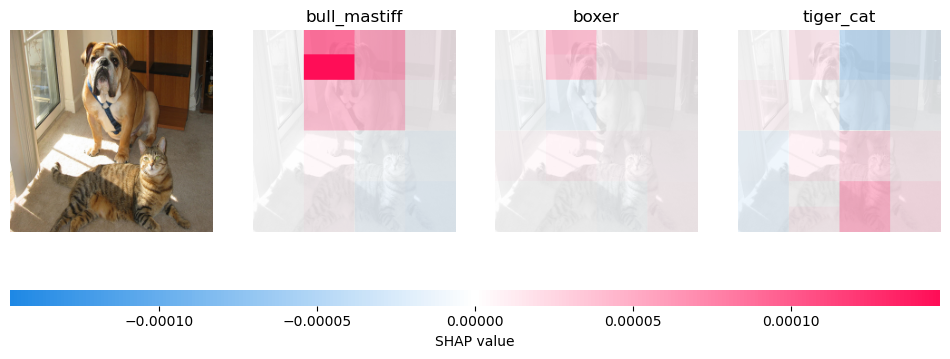

In [3]:
# Python function to get model output; replace this function with your own model function
def f(x):
    tmp = x.copy()
    tmp = preprocess_input(tmp)
    return model(tmp)

# Load and preprocess your image
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def load_img(path):
    img = image.load_img(path, target_size=(224, 224, 3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x
image_path = 'catdog.png'
img, x = load_img(image_path)
# Load your image
# Replace 'path_to_your_image.jpg' with the actual path to your image file
img_array = load_and_preprocess_image(image_path)

# Define the masker used to mask out partitions of the input image
masker = shap.maskers.Image("inpaint_telea", (224, 224, 3))

# Create an explainer with the model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)
predictions = model(x)

# Decode the top 3 predictions to class names
decoded_predictions = decode_predictions(predictions.numpy(), top=3)
print("Decoded predictions:")
for i, (imagenet_id, class_name, score) in enumerate(decoded_predictions[0]):
    print(f"  {i+1}: {class_name} (score: {score:.4f})")

# Here we explain the image using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(img_array, max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:3])

# Visualize the SHAP values
shap.image_plot(shap_values, img_array)
